### Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import os
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

### utils

In [2]:
## Set random seed
def set_seed(seed=42):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## Data Preparation
def read_data(dataPath):
    data = pd.read_csv(dataPath).drop('Unnamed: 0',axis=1).rename(columns={'index': 'Seq'})
    data['Position'] = data['Position'].replace(np.nan, '{}')
    data['Position'] = data['Position'].apply(ast.literal_eval)
    return data

def prepare_data(data, max_positions=16):
    # Standardization
    data[['A2P', 'A1P', 'B1P', 'B2P', 'Price']] = data[['A2P', 'A1P', 'B1P', 'B2P', 'Price']] / 1e4
    data[['A2V', 'A1V', 'B1V', 'B2V', 'Volume']] = np.log(data[['A2V', 'A1V', 'B1V', 'B2V', 'Volume']] + 1)
    
    # lob_cols = ['A2P', 'A2V', 'A1P', 'A1V', 'B1P', 'B1V', 'B2P', 'B2V']
    lob_cols = ['A2P', 'A1P', 'B1P', 'B2P', 'A2V', 'A1V', 'B1V', 'B2V']
    state_cols = ['Cash', 'Inventory']
    action_cols = ['Price', 'Volume', 'Type', 'Direction']

    # Flatten positions
    def flatten_position_vectorized(position_series, max_positions):
        def flatten_pos(pos):
            if len(pos) == 0:
                return np.zeros(3 * max_positions)
            else:
                pos_array = np.array(list(pos.values()), dtype=float)
                pos_array[:, 0] /= 1e4  # Scale prices
                pos_array[:, 1] = np.log(pos_array[:, 1] + 1)
                pos_array[:, 2] = pos_array[:, 3]
                pos_array[:, 2] = np.log(pos_array[:, 2] + 1)
                pos_array = pos_array[:, :-1]
                flat_position = pos_array.flatten()
                if len(flat_position) < 3 * max_positions:
                    flat_position = np.concatenate([flat_position, np.zeros(3 * max_positions - len(flat_position))])
                return flat_position[:3 * max_positions]
        
        tqdm.pandas(desc='apply')
        flattened = position_series.progress_apply(flatten_pos)
        return np.stack(flattened.values)

    flattened_positions = flatten_position_vectorized(data['Position'], max_positions)
    
    # Prepare observations and next observations
    observations = np.concatenate([data[state_cols].values, data[lob_cols].values, flattened_positions], axis=1)
    next_observations = data[lob_cols].shift(-1).iloc[:-1].values

    # Prepare actions
    actions = data[action_cols].iloc[:-1]
    actions = pd.get_dummies(actions, columns=['Type', 'Direction']).values

    observations = torch.tensor(observations[:-1], dtype=torch.float32)
    actions = torch.tensor(actions.astype(float), dtype=torch.float32)
    next_observations = torch.tensor(next_observations.astype(float), dtype=torch.float32)
    
    return observations, actions, next_observations

class CustomDataset(Dataset):
    def __init__(self, observations, actions, next_observations):
        self.observations = observations
        self.actions = actions
        self.next_observations = next_observations
    
    def __len__(self):
        return len(self.observations)
    
    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx], self.next_observations[idx]

# Standardisation within each batch
def batch_standardize(batch):
    observations, actions, next_observations = zip(*batch)
    
    observations = torch.stack(observations)
    actions = torch.stack(actions)
    next_observations = torch.stack(next_observations)
    
    # Standardize within the batch
    observations_mean = observations.mean(dim=0)
    observations_std = observations.std(dim=0)
    actions_mean = actions.mean(dim=0)
    actions_std = actions.std(dim=0)
    next_obs_mean = next_observations.mean(dim=0)
    next_obs_std = next_observations.std(dim=0)

    # Avoid division by zero
    observations_std[observations_std == 0] = 1
    actions_std[actions_std == 0] = 1
    next_obs_std[next_obs_std == 0] = 1
    
    standardized_observations = (observations - observations_mean) / observations_std
    standardized_actions = (actions - actions_mean) / actions_std
    standardized_next_observations = (next_observations - next_obs_mean) / next_obs_std

    standardized_observations = torch.nan_to_num(standardized_observations, nan=0.0)
    standardized_actions = torch.nan_to_num(standardized_actions, nan=0.0)
    standardized_next_observations = torch.nan_to_num(standardized_next_observations, nan=0.0)
    
    return standardized_observations, standardized_actions, standardized_next_observations, next_obs_mean, next_obs_std


# split the dataset into training, validating and testing
def split_dataset(observations, actions, next_observations, train_size=0.7, val_size=0.15):
    # Split into train + validation and test
    obs_train, obs_temp, act_train, act_temp, next_obs_train, next_obs_temp = train_test_split(
        observations, actions, next_observations, test_size=(1 - train_size), random_state=42, shuffle=False
    )
    
    # Split temp into validation and test
    val_size_adj = val_size / (1 - train_size)  # Adjust validation size based on remaining data
    obs_val, obs_test, act_val, act_test, next_obs_val, next_obs_test = train_test_split(
        obs_temp, act_temp, next_obs_temp, test_size=(1 - val_size_adj), random_state=42, shuffle=False
    )
    
    return obs_train, obs_val, obs_test, act_train, act_val, act_test, next_obs_train, next_obs_val, next_obs_test

def evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim):
    autoencoder.eval()
    total_test_loss = 0
    criterion = nn.MSELoss()

    predictions = []
    actuals = []
    
    with torch.no_grad():
        prev_state = torch.zeros((batch_size, state_dim))
        prev_action = torch.zeros((batch_size, action_dim))
        for obs, action, next_obs, next_obs_mean, next_obs_std in test_loader:
            prediction, state = autoencoder(obs, action, prev_state, prev_action)
            loss = criterion(prediction, next_obs)
            total_test_loss += loss.item()
            prev_state = state.detach()
            prev_action = action.detach()
            restored_prediction = (prediction * next_obs_std) + next_obs_mean
            restored_actual = (next_obs * next_obs_std) + next_obs_mean
            restored_prediction[:, :4] = torch.round(restored_prediction[:, :4], decimals=2)
            restored_actual[:, :4] = torch.round(restored_actual[:, :4], decimals=2)
            restored_prediction[:, -4:] = torch.round(torch.exp(restored_prediction[:, -4:]))
            restored_actual[:, -4:] = torch.round(torch.exp(restored_actual[:, -4:]))
            predictions.append(restored_prediction.numpy())
            actuals.append(restored_actual.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    avg_test_loss = total_test_loss / len(test_loader)
    print('---')
    print(f'Test Loss: {avg_test_loss:.4f}')

    # Output the first few predictions and actuals for inspection
    for i in range(5):
        print('---')
        print(f"Prediction {i+1}: {predictions[i]}")
        print(f"Actual {i+1}: {actuals[i]}")

def data_init():
    dataPath = '/Users/sw/Working Space/Python/nmdp_rl/data/dataset_with_percentile/'
    file_list = sorted(os.listdir(dataPath))
    file_list = file_list[1:61]
    data  = pd.DataFrame()
    for file in tqdm(file_list):
        item_path = os.path.join(dataPath, file)
        data_intraday = read_data(item_path)
        data = pd.concat((data,data_intraday),axis=0)
    return data

### Hyperparameters and Data Initialisation

In [4]:
# data = data_init()
# data['Seq'] = range(len(data))
# data.to_csv('/Users/sw/Working Space/Python/nmdp_rl/data/dataset_with_percentile/data.csv')
data = read_data('/Users/sw/Working Space/Python/nmdp_rl/data/dataset_with_percentile/data.csv')

In [5]:
set_seed(42)
# data = read_data('/Users/sw/Working Space/Python/nmdp_rl/data/dataset_with_percentile/AAPL_2019-01-02_dataset_2ls.csv')
observations, actions, next_observations = prepare_data(data.copy())
obs_train, obs_val, obs_test, act_train, act_val, act_test, next_obs_train, next_obs_val, next_obs_test = split_dataset(
    observations, actions, next_observations
)

# Hyperparameters
state_dim = 32
action_dim = actions.shape[1]
input_dim = observations.shape[1] + state_dim + action_dim
hidden_dim = input_dim
output_dim = next_observations.shape[1]
num_layers = 8  # Adjust the depth of the network
batch_size = 1024
epochs = 100
learning_rate = 1e-4

output_dims = {'price': 4, 'volume': 4}  # Output dimensions for price and volume
attention_dim = input_dim
conv_filters = input_dim
kernel_size = 5

# Prepare DataLoader
train_dataset = CustomDataset(obs_train, act_train, next_obs_train)
val_dataset = CustomDataset(obs_val, act_val, next_obs_val)
test_dataset = CustomDataset(obs_test, act_test, next_obs_test)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False, collate_fn=batch_standardize, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=batch_standardize, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=batch_standardize, drop_last=True)

apply: 100%|██████████| 1569245/1569245 [00:05<00:00, 266782.39it/s]


### AE_simple

Epoch 1, Train Loss: 0.6121, Val Loss: 0.5067
Epoch 2, Train Loss: 0.5056, Val Loss: 0.5060
Epoch 3, Train Loss: 0.5051, Val Loss: 0.5053
Epoch 4, Train Loss: 0.4983, Val Loss: 0.4759
Epoch 5, Train Loss: 0.4756, Val Loss: 0.4719
Epoch 6, Train Loss: 0.4732, Val Loss: 0.4710
Epoch 7, Train Loss: 0.4719, Val Loss: 0.4698
Epoch 8, Train Loss: 0.4706, Val Loss: 0.4689
Epoch 9, Train Loss: 0.4698, Val Loss: 0.4684
Epoch 10, Train Loss: 0.4694, Val Loss: 0.4682
Epoch 11, Train Loss: 0.4690, Val Loss: 0.4681
Epoch 12, Train Loss: 0.4687, Val Loss: 0.4680
Epoch 13, Train Loss: 0.4684, Val Loss: 0.4680
Epoch 14, Train Loss: 0.4680, Val Loss: 0.4679
Epoch 15, Train Loss: 0.4676, Val Loss: 0.4677
Epoch 16, Train Loss: 0.4671, Val Loss: 0.4672
Epoch 17, Train Loss: 0.4664, Val Loss: 0.4665
Epoch 18, Train Loss: 0.4653, Val Loss: 0.4653
Epoch 19, Train Loss: 0.4638, Val Loss: 0.4633
Epoch 20, Train Loss: 0.4622, Val Loss: 0.4611
Epoch 21, Train Loss: 0.4606, Val Loss: 0.4592
Epoch 22, Train Loss: 

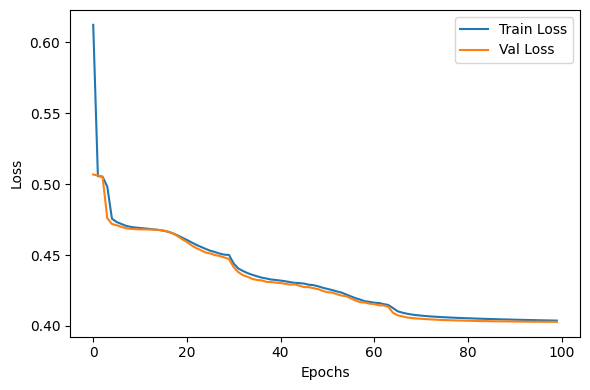

---
Test Loss: 0.4403
---
Prediction 1: [186.98 186.97 186.95 186.94 486.   225.   194.   613.  ]
Actual 1: [186.98 186.97 186.96 186.95 701.   101.   301.   401.  ]
---
Prediction 2: [186.99 186.98 186.96 186.95 483.   180.   244.   435.  ]
Actual 2: [ 186.98  186.97  186.95  186.94  301.    101.    101.   1001.  ]
---
Prediction 3: [186.98 186.97 186.95 186.94 376.   173.   178.   637.  ]
Actual 3: [186.96 186.95 186.93 186.92 101.   101.   301.   906.  ]
---
Prediction 4: [186.96 186.95 186.94 186.93 301.   152.   230.   666.  ]
Actual 4: [186.95 186.94 186.92 186.91 402.   511.     6.   701.  ]
---
Prediction 5: [186.94 186.93 186.92 186.9  372.   216.   112.   549.  ]
Actual 5: [186.95 186.94 186.93 186.92 101.     2.   201.   606.  ]


In [6]:
## Model definition
# Define the Encoder with configurable depth
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, num_layers):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_layers = nn.ModuleList()

        # Initialize hidden layers
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        if num_layers > 1:
            self.hidden_layers.append(nn.Linear(hidden_dim, state_dim))
        else:
            self.hidden_layers[0] = nn.Linear(input_dim, state_dim)
        # self.relu = nn.ReLU()

    def forward(self, observation, prev_state, prev_action):
        # combine O(n), S(n-1), U(n-1)
        x = torch.cat((observation, prev_state, prev_action), dim=1)
        for layer in self.hidden_layers:
            x = F.leaky_relu(layer(x))
        return x

# Define the Decoder with configurable depth
class Decoder(nn.Module):
    def __init__(self, state_dim, action_dim, output_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_layers = nn.ModuleList()
        # Add first layer
        self.hidden_layers.append(nn.Linear(state_dim + action_dim, hidden_dim))
        # Add subsequent hidden layers
        for _ in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        # self.relu = nn.ReLU()
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        for i in range(self.num_layers):
            x = F.leaky_relu(self.hidden_layers[i](x))
        x = self.output_layer(x)
        return x

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dim, num_layers):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, state_dim, num_layers)
        self.decoder = Decoder(state_dim, action_dim, output_dim, hidden_dim, num_layers)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


## Model Training
def train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        autoencoder.train()
        total_train_loss = 0
        prev_state = torch.zeros((batch_size, state_dim))  # initialize prev_state as 0
        prev_action = torch.zeros((batch_size, action_dim))  # initialize prev_action as 0
        
        for obs, action, next_obs, _, _ in train_loader:
            optimizer.zero_grad()
            prediction, state = autoencoder(obs, action, prev_state, prev_action)
            loss = criterion(prediction, next_obs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            prev_state = state.detach()  # update prev_state with the current state
            prev_action = action.detach()  # update prev_actionwith the current action
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        autoencoder.eval()
        total_val_loss = 0
        with torch.no_grad():
            prev_state = torch.zeros((batch_size, state_dim))
            prev_action = torch.zeros((batch_size, action_dim))

            for obs, action, next_obs, _, _ in val_loader:
                prediction, state = autoencoder(obs, action, prev_state, prev_action)
                loss = criterion(prediction, next_obs)
                total_val_loss += loss.item()
                
                prev_state = state.detach()
                prev_action = action.detach()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Instantiate and train the model
autoencoder = Autoencoder(input_dim, hidden_dim, state_dim, action_dim, output_dim, num_layers)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)

### AE_MultiTask

Epoch 1, Train Loss: 1.1884, Val Loss: 1.0131
Epoch 2, Train Loss: 1.0110, Val Loss: 1.0120
Epoch 3, Train Loss: 1.0106, Val Loss: 1.0118
Epoch 4, Train Loss: 1.0104, Val Loss: 1.0115
Epoch 5, Train Loss: 1.0103, Val Loss: 1.0113
Epoch 6, Train Loss: 1.0102, Val Loss: 1.0111
Epoch 7, Train Loss: 1.0101, Val Loss: 1.0110
Epoch 8, Train Loss: 1.0095, Val Loss: 1.0049
Epoch 9, Train Loss: 0.9615, Val Loss: 0.9443
Epoch 10, Train Loss: 0.9461, Val Loss: 0.9399
Epoch 11, Train Loss: 0.9434, Val Loss: 0.9377
Epoch 12, Train Loss: 0.9416, Val Loss: 0.9359
Epoch 13, Train Loss: 0.9400, Val Loss: 0.9339
Epoch 14, Train Loss: 0.9383, Val Loss: 0.9320
Epoch 15, Train Loss: 0.9363, Val Loss: 0.9297
Epoch 16, Train Loss: 0.9341, Val Loss: 0.9269
Epoch 17, Train Loss: 0.9320, Val Loss: 0.9244
Epoch 18, Train Loss: 0.9299, Val Loss: 0.9219
Epoch 19, Train Loss: 0.9274, Val Loss: 0.9199
Epoch 20, Train Loss: 0.9250, Val Loss: 0.9172
Epoch 21, Train Loss: 0.9218, Val Loss: 0.9138
Epoch 22, Train Loss: 

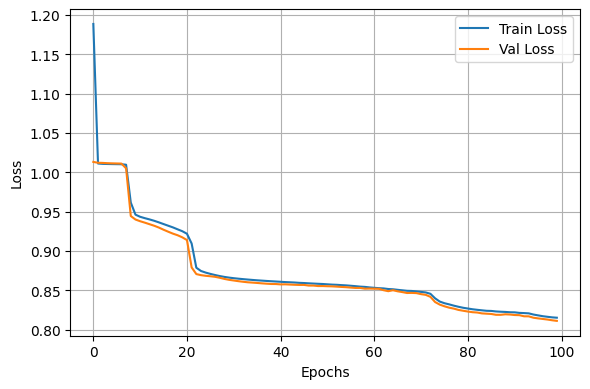

---
Test Loss: 0.4423
---
Prediction 1: [186.97 186.96 186.94 186.93 473.   212.   191.   599.  ]
Actual 1: [186.98 186.97 186.96 186.95 701.   101.   301.   401.  ]
---
Prediction 2: [186.99 186.98 186.96 186.95 445.   172.   228.   443.  ]
Actual 2: [ 186.98  186.97  186.95  186.94  301.    101.    101.   1001.  ]
---
Prediction 3: [186.98 186.97 186.95 186.94 356.   151.   176.   646.  ]
Actual 3: [186.96 186.95 186.93 186.92 101.   101.   301.   906.  ]
---
Prediction 4: [186.97 186.96 186.94 186.93 325.   165.   195.   628.  ]
Actual 4: [186.95 186.94 186.92 186.91 402.   511.     6.   701.  ]
---
Prediction 5: [186.96 186.95 186.93 186.92 412.   200.   101.   495.  ]
Actual 5: [186.95 186.94 186.93 186.92 101.     2.   201.   606.  ]


In [7]:
## Model definition
# Inherit from Decoder in AE_simple.py
class MultiTaskDecoder(Decoder):
    def __init__(self, state_dim, action_dim, hidden_dim, num_layers, output_dims):
        super(MultiTaskDecoder, self).__init__(state_dim, action_dim, hidden_dim, hidden_dim, num_layers)
        
        # Separate output layers for price and volume
        self.price_decoder = nn.Linear(hidden_dim, output_dims['price'])
        self.volume_decoder = nn.Linear(hidden_dim, output_dims['volume'])

    def forward(self, state, action):
        # Use the forward method from the Decoder class for the shared layers
        x = super(MultiTaskDecoder, self).forward(state, action)
        
        # Separate predictions for price and volume
        price_pred = self.price_decoder(x)
        volume_pred = self.volume_decoder(x)
        
        # Combine predictions
        return torch.cat((price_pred, volume_pred), dim=1)

# Define the MultiTaskAutoencoder
class MultiTaskAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers):
        super(MultiTaskAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, state_dim, num_layers)
        self.decoder = MultiTaskDecoder(state_dim, action_dim, hidden_dim, num_layers, output_dims)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


## Model Training
def train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        autoencoder.train()
        total_train_loss = 0
        prev_state = torch.zeros((batch_size, state_dim))  # initialize prev_state as 0
        prev_action = torch.zeros((batch_size, action_dim))  # initialize prev_action as 0

        for obs, action, next_obs, _, _ in train_loader:
            optimizer.zero_grad()
            prediction, state = autoencoder(obs, action, prev_state, prev_action)

            # Separate loss for price and volume
            loss_price = criterion(prediction[:, :4], next_obs[:, :4])
            loss_volume = criterion(prediction[:, 4:], next_obs[:, 4:])
            loss = loss_price + loss_volume
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            prev_state = state.detach()  # update prev_state with the current state
            prev_action = action.detach()  # update prev_actionwith the current action
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        autoencoder.eval()
        total_val_loss = 0
        with torch.no_grad():
            prev_state = torch.zeros((batch_size, state_dim))
            prev_action = torch.zeros((batch_size, action_dim))

            for obs, action, next_obs, _, _ in val_loader:
                prediction, state = autoencoder(obs, action, prev_state, prev_action)
                # Separate loss for price and volume
                loss_price = criterion(prediction[:, :4], next_obs[:, :4])
                loss_volume = criterion(prediction[:, 4:], next_obs[:, 4:])
                loss = loss_price + loss_volume
                total_val_loss += loss.item()

                prev_state = state.detach()
                prev_action = action.detach()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Instantiate and train the model
autoencoder = MultiTaskAutoencoder(input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)

### AE_MT_Attention

Epoch 1, Train Loss: 1.2414, Val Loss: 1.0113
Epoch 2, Train Loss: 1.0103, Val Loss: 1.0109
Epoch 3, Train Loss: 1.0101, Val Loss: 1.0109
Epoch 4, Train Loss: 1.0101, Val Loss: 1.0108
Epoch 5, Train Loss: 1.0101, Val Loss: 1.0108
Epoch 6, Train Loss: 1.0100, Val Loss: 1.0107
Epoch 7, Train Loss: 1.0100, Val Loss: 1.0106
Epoch 8, Train Loss: 1.0099, Val Loss: 1.0106
Epoch 9, Train Loss: 1.0098, Val Loss: 1.0104
Epoch 10, Train Loss: 1.0096, Val Loss: 1.0099
Epoch 11, Train Loss: 1.0080, Val Loss: 0.9821
Epoch 12, Train Loss: 0.9526, Val Loss: 0.9445
Epoch 13, Train Loss: 0.9467, Val Loss: 0.9414
Epoch 14, Train Loss: 0.9438, Val Loss: 0.9394
Epoch 15, Train Loss: 0.9425, Val Loss: 0.9389
Epoch 16, Train Loss: 0.9418, Val Loss: 0.9385
Epoch 17, Train Loss: 0.9413, Val Loss: 0.9380
Epoch 18, Train Loss: 0.9408, Val Loss: 0.9374
Epoch 19, Train Loss: 0.9403, Val Loss: 0.9364
Epoch 20, Train Loss: 0.9396, Val Loss: 0.9354
Epoch 21, Train Loss: 0.9382, Val Loss: 0.9340
Epoch 22, Train Loss: 

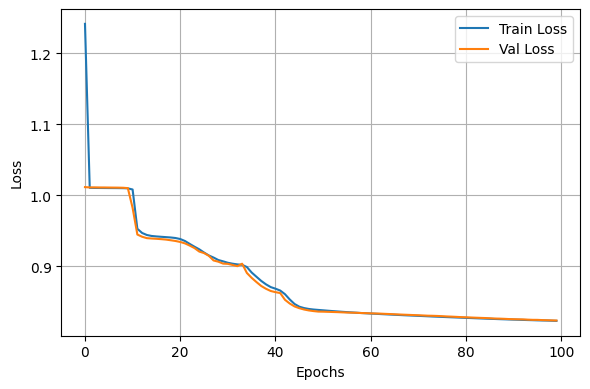

---
Test Loss: 0.4457
---
Prediction 1: [186.98 186.97 186.95 186.94 466.   215.   211.   617.  ]
Actual 1: [186.98 186.97 186.96 186.95 701.   101.   301.   401.  ]
---
Prediction 2: [186.99 186.98 186.96 186.95 435.   192.   232.   419.  ]
Actual 2: [ 186.98  186.97  186.95  186.94  301.    101.    101.   1001.  ]
---
Prediction 3: [186.98 186.97 186.95 186.94 382.   150.   198.   662.  ]
Actual 3: [186.96 186.95 186.93 186.92 101.   101.   301.   906.  ]
---
Prediction 4: [186.97 186.96 186.94 186.93 310.   129.   260.   605.  ]
Actual 4: [186.95 186.94 186.92 186.91 402.   511.     6.   701.  ]
---
Prediction 5: [186.95 186.94 186.92 186.91 423.   210.    88.   512.  ]
Actual 5: [186.95 186.94 186.93 186.92 101.     2.   201.   606.  ]


In [8]:
## Model definition
# Define the Attention Mechanism
class Attention(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super(Attention, self).__init__()
        self.query_layer = nn.Linear(input_dim, attention_dim)
        self.key_layer = nn.Linear(input_dim, attention_dim)
        self.value_layer = nn.Linear(input_dim, attention_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
         # Ensure x is 3D: (batch_size, seq_len, feature_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add a dimension to make it 3D
        # Query, Key, Value
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Scaled Dot-Product Attention
        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (key.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)

        # Apply attention weights to the values
        attended_values = torch.bmm(attention_weights, value)
        return attended_values, attention_weights

# Define the Encoder with Attention
class EncoderWithAttention(Encoder):
    def __init__(self, input_dim, hidden_dim, state_dim, num_layers, attention_dim):
        # Initialize the parent class (Encoder)
        super(EncoderWithAttention, self).__init__(input_dim, hidden_dim, state_dim, num_layers)
        # Add attention layer
        self.attention = Attention(input_dim, attention_dim)
    
    def forward(self, observation, prev_state, prev_action):
        # Combine observation, previous state, and previous action
        x = torch.cat((observation, prev_state, prev_action), dim=1)
        # Apply attention mechanism before passing through the hidden layers
        x, _ = self.attention(x)
        # Pass through the hidden layers from the parent class
        for layer in self.hidden_layers:
            x = F.leaky_relu(layer(x))
        return x.squeeze(1)


# Define the Autoencoder
class AutoencoderWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim):
        super(AutoencoderWithAttention, self).__init__()
        self.encoder = EncoderWithAttention(input_dim, hidden_dim, state_dim, num_layers, attention_dim)
        self.decoder = MultiTaskDecoder(state_dim, action_dim, hidden_dim, num_layers, output_dims)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


# Instantiate and train the model
autoencoder = AutoencoderWithAttention(input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)

### AE_MT_AT_CNN

Epoch 1, Train Loss: 1.2580, Val Loss: 1.0119
Epoch 2, Train Loss: 1.0107, Val Loss: 1.0110
Epoch 3, Train Loss: 1.0103, Val Loss: 1.0109
Epoch 4, Train Loss: 1.0102, Val Loss: 1.0108
Epoch 5, Train Loss: 1.0100, Val Loss: 1.0105
Epoch 6, Train Loss: 1.0097, Val Loss: 1.0101
Epoch 7, Train Loss: 1.0094, Val Loss: 1.0095
Epoch 8, Train Loss: 1.0090, Val Loss: 1.0091
Epoch 9, Train Loss: 1.0087, Val Loss: 1.0089
Epoch 10, Train Loss: 1.0085, Val Loss: 1.0088
Epoch 11, Train Loss: 1.0085, Val Loss: 1.0088
Epoch 12, Train Loss: 1.0084, Val Loss: 1.0088
Epoch 13, Train Loss: 1.0084, Val Loss: 1.0087
Epoch 14, Train Loss: 1.0083, Val Loss: 1.0087
Epoch 15, Train Loss: 1.0083, Val Loss: 1.0087
Epoch 16, Train Loss: 1.0083, Val Loss: 1.0087
Epoch 17, Train Loss: 1.0082, Val Loss: 1.0087
Epoch 18, Train Loss: 1.0082, Val Loss: 1.0086
Epoch 19, Train Loss: 1.0082, Val Loss: 1.0087
Epoch 20, Train Loss: 1.0082, Val Loss: 1.0086
Epoch 21, Train Loss: 1.0081, Val Loss: 1.0082
Epoch 22, Train Loss: 

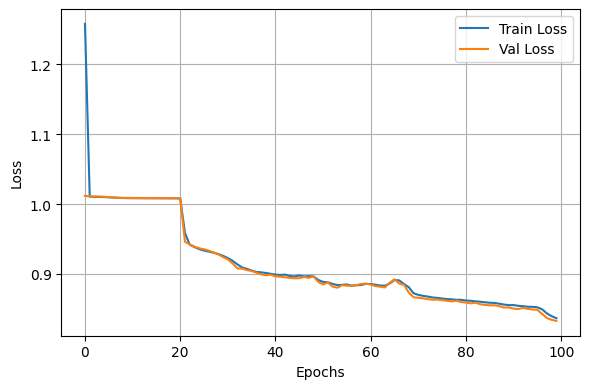

---
Test Loss: 0.4491
---
Prediction 1: [186.98 186.97 186.95 186.94 456.   231.   188.   673.  ]
Actual 1: [186.98 186.97 186.96 186.95 701.   101.   301.   401.  ]
---
Prediction 2: [186.99 186.98 186.97 186.96 469.   156.   216.   455.  ]
Actual 2: [ 186.98  186.97  186.95  186.94  301.    101.    101.   1001.  ]
---
Prediction 3: [186.98 186.97 186.95 186.94 419.   139.   183.   686.  ]
Actual 3: [186.96 186.95 186.93 186.92 101.   101.   301.   906.  ]
---
Prediction 4: [186.96 186.95 186.94 186.92 310.   157.   264.   596.  ]
Actual 4: [186.95 186.94 186.92 186.91 402.   511.     6.   701.  ]
---
Prediction 5: [186.95 186.94 186.92 186.91 483.   233.   105.   548.  ]
Actual 5: [186.95 186.94 186.93 186.92 101.     2.   201.   606.  ]


In [9]:
## Model definition
class EncoderWithAttentionAndCNN(EncoderWithAttention):
    def __init__(self, input_dim, hidden_dim, state_dim, num_layers, attention_dim, conv_filters, kernel_size):
        # Initialize the parent class (EncoderWithAttention)
        super(EncoderWithAttentionAndCNN, self).__init__(input_dim, hidden_dim, state_dim, num_layers, attention_dim)
        # Add 1D Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=conv_filters, kernel_size=kernel_size, padding=kernel_size//2)
        # Override attention layer to match the output of conv1d
        self.attention = Attention(conv_filters, attention_dim)
        # Override hidden layers
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(conv_filters, hidden_dim))
        for _ in range(num_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        if num_layers > 1:
            self.hidden_layers.append(nn.Linear(hidden_dim, state_dim))
        else:
            self.hidden_layers[0] = nn.Linear(conv_filters, state_dim)

    def forward(self, observation, prev_state, prev_action):
        # Combine observation, previous state, and previous action
        x = torch.cat((observation, prev_state, prev_action), dim=1)
        # Apply attention mechanism before passing through the hidden layers
        if x.dim() == 2:  # Ensure x is 3D: (batch_size, seq_len, feature_dim)
            x = x.unsqueeze(1)
        # Apply 1D Convolution
        x = x.permute(0, 2, 1)  # Change dimension to (batch_size, feature_dim, seq_len)
        x = F.relu(self.conv1d(x))
        x = x.permute(0, 2, 1)  # Change back to (batch_size, seq_len, conv_filters)
        # Apply attention mechanism (inherited from EncoderWithAttention)
        x, _ = self.attention(x)
        # Pass through the hidden layers (inherited from EncoderWithAttention)
        for layer in self.hidden_layers:
            x = F.leaky_relu(layer(x))
        return x.squeeze(1)


# Define the Autoencoder
class AutoencoderWithAttentionAndCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim, conv_filters, kernel_size):
        super(AutoencoderWithAttentionAndCNN, self).__init__()
        self.encoder = EncoderWithAttentionAndCNN(input_dim, hidden_dim, state_dim, num_layers, attention_dim, conv_filters, kernel_size)
        self.decoder = MultiTaskDecoder(state_dim, action_dim, hidden_dim, num_layers, output_dims)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


# Instantiate and train the model
autoencoder = AutoencoderWithAttentionAndCNN(input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim, conv_filters, kernel_size)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)